<a href="https://colab.research.google.com/github/robjmenna/RBE595_deeplearning_final/blob/main/Copy_of_Untitled5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

In [ ]:
class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        """ Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
            )
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results


In [ ]:
import tensorflow_datasets as tfds

test = tfds.load('imagenette', split='validation')

Shuffling and writing examples to /root/tensorflow_datasets/imagenette/full-size-v2/0.1.0.incompleteNMRZEE/imagenette-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imagenette/full-size-v2/0.1.0.incompleteNMRZEE/imagenette-validation.tfrecord


Dataset imagenette downloaded and prepared to /root/tensorflow_datasets/imagenette/full-size-v2/0.1.0. Subsequent calls will reuse this data.


label: 9


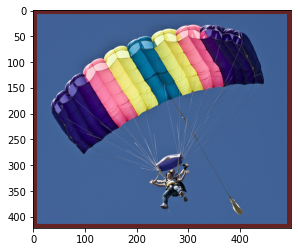

In [ ]:
import matplotlib.pyplot as plt
import requests  # the lib that handles the url stuff

label_url = 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt'
blob = requests.get(label_url).text.split('\n')
labels = np.array([str(line) for line in blob])
ds = test.map(lambda x: (x['image'], x['label']))

ex = next(ds.take(1).as_numpy_iterator())
plt.imshow(ex[0])
print('label: ' + str(ex[1]))
ds = ds.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, tf.one_hot(y,1001))).batch(1)

In [ ]:
import tensorflow_hub as hub

m = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/resnet_v2_152/classification/4")
])
m.build([None, 224, 224, 3])  # Batch input shape.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              60382697  
Total params: 60,382,697
Trainable params: 0
Non-trainable params: 60,382,697
_________________________________________________________________
None


1/1 [==============================] - 0s 37ms/step
score: 9.036275
label: English springer


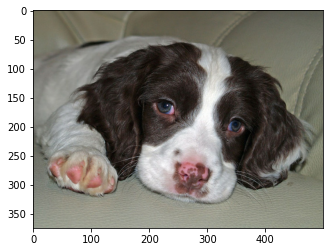

In [ ]:
sample = ds.skip(3).take(1)
img, scores = next(sample.as_numpy_iterator())

scores = m.predict(sample, verbose=1)
plt.imshow(img[0,:,:,:])

print('score: ' + str(np.max(scores)))
i = np.argmax(scores)
print('label: ' + labels[i])